In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

xFormers not available
xFormers not available


In [2]:
IMAGE_SIZE = 1120 
PATCH_DIM = IMAGE_SIZE //14
IDX = 0 #id of the object in the category

In [3]:
args_infer = {
    "model_path" : "runs/bottle_1_single.ckpt",
    "device" : "cuda",
    "img_size" : IMAGE_SIZE
}

In [4]:
device = torch.device(args_infer["device"]) if torch.cuda.is_available() else torch.device("cpu")
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=IMAGE_SIZE,int_dim=256,output_dim=128,input_cls=3)
dataset = JacquardSamples(image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"],idx=IDX)
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

In [6]:
split_test = 'Bottle_train/'
split_train = 'Bottle_test/'

In [8]:
device = torch.device(args_infer["device"]) if torch.cuda.is_available() else torch.device("cpu")
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=IMAGE_SIZE,int_dim=256,output_dim=128,input_cls=3)
dataset_train = JacquardSamples(dataset_root= split_train ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=4)
dataset = JacquardSamples(dataset_root= split_test ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=7)
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

In [16]:
test_idx = 0 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = dataset[test_idx]
img = data["img"].to(device)
mask = data["mask"].to(device)
img = torch.permute(img, (0, 2, 1))
print(img.shape)
grasp = data["points_grasp"]//14
grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
grasp = torch.cat([grasp, grasp_inv], dim=0)


features,_ = model.forward_dino_features(img.unsqueeze(0))
features = features.squeeze().reshape(PATCH_DIM, PATCH_DIM, 768)

torch.Size([3, 1120, 1120])


/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)


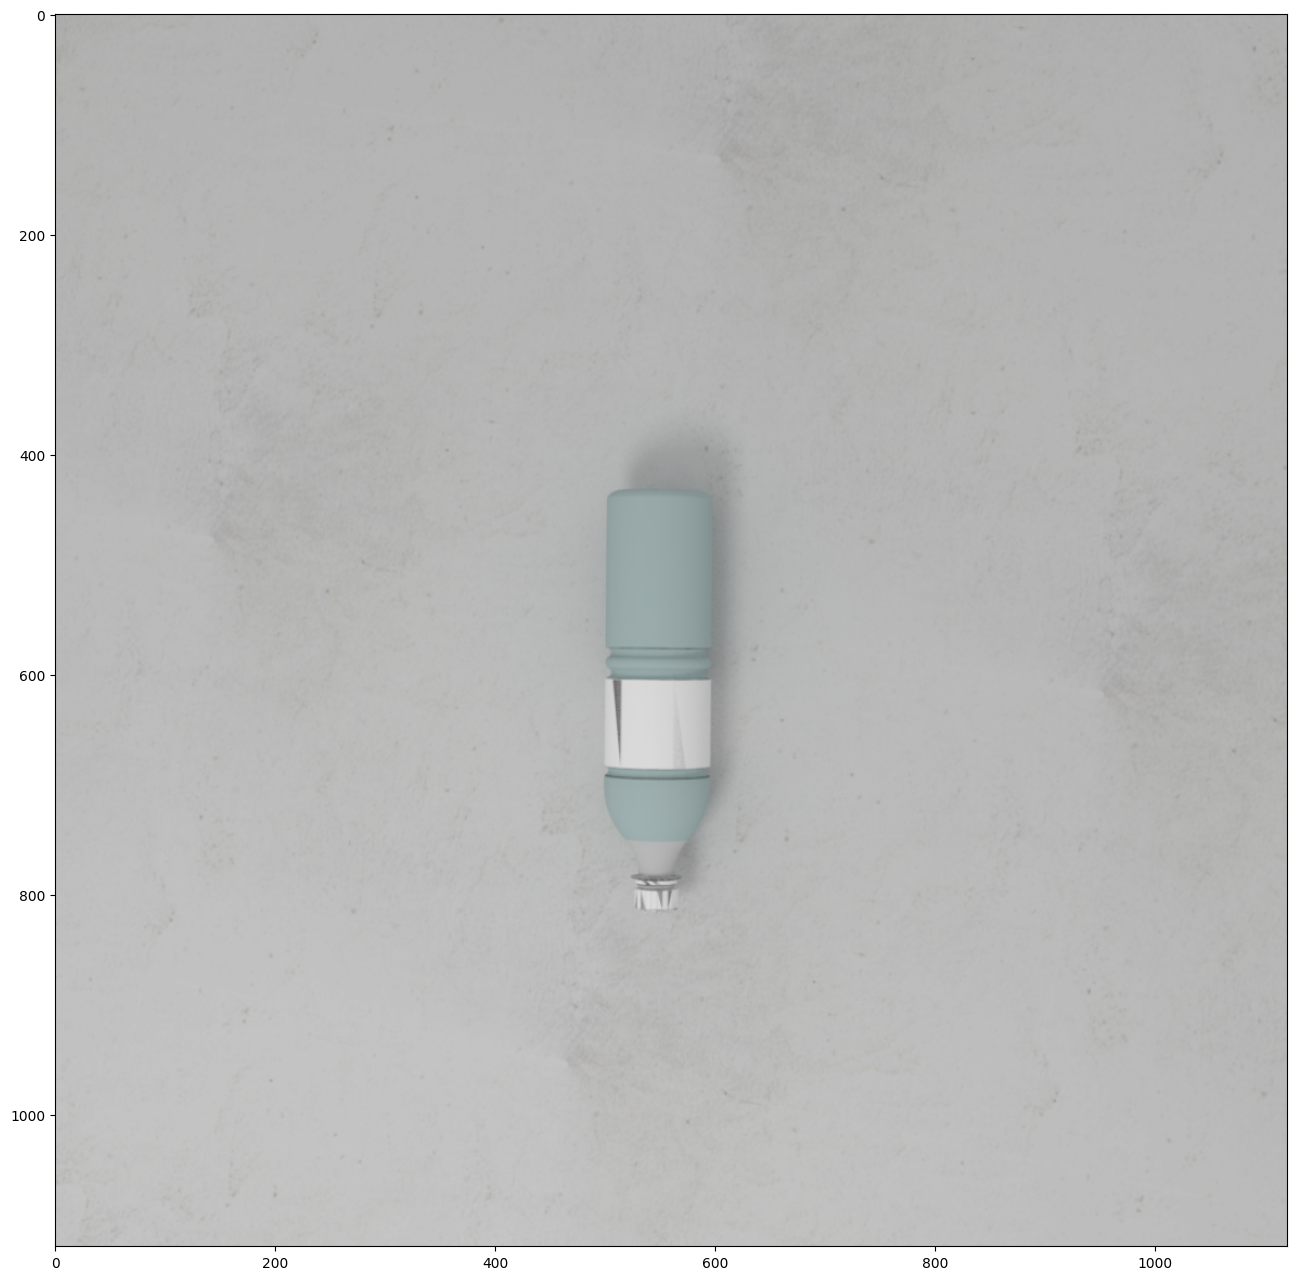

In [17]:
plt.figure(figsize=(16,16))
org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
plt.imshow(org_image)

# Test gt points certainty

In [18]:
all_points = grasp
mean_feats=[]
diffs = []
patch_area = 1
for i in range(all_points.shape[0]):
    pt1 = all_points[i,0,:]
    pt2 = all_points[i,1,:]
                    
    features_1 = features[pt1[0]:pt1[0]+patch_area, pt1[1]:pt1[1]+patch_area, :]
    features_1 = features_1.reshape(features_1.shape[0] * features_1.shape[1], features_1.shape[2]).mean(0)
    
    features_2 = features[pt2[0]:pt2[0]+patch_area, pt2[1]:pt2[1]+patch_area, :]
    features_2 = features_2.reshape(features_2.shape[0] * features_2.shape[1], features_2.shape[2]).mean(0)
    
                
    if i == 0:
        mean_feats = features_1.unsqueeze(0)
        mean_feats = torch.cat([mean_feats, features_2.unsqueeze(0)], dim=0)
    else:
        mean_feats = torch.cat([mean_feats, features_1.unsqueeze(0)], dim=0)
        mean_feats = torch.cat([mean_feats, features_2.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model.forward_valid(mean_feats.to(device))

In [19]:
print(preds.mean())

tensor(0.3310, device='cuda:0')


# Test single point

In [20]:

all_points = torch.tensor([[i,j] for j in range(PATCH_DIM) for i in range(PATCH_DIM)]).unsqueeze(1).to(device)
print(all_points.shape)
print(all_points[0])
#all_points = all_points.reshape(1,2,1)
#all_points = torch.cat([single_point, all_points], dim=1).to(device)

torch.Size([6400, 1, 2])
tensor([[0, 0]], device='cuda:0')


In [31]:
mean_feats=[]
diffs = []
patch_area = 1
for i in range(all_points.shape[0]):
    pt1 = all_points[i,0,:]
                    
    features_1 = features[pt1[0]:pt1[0]+patch_area, pt1[1]:pt1[1]+patch_area, :]
    features_1 = features_1.reshape(features_1.shape[0] * features_1.shape[1], features_1.shape[2]).mean(0)

                
    if i == 0:
        mean_feats = features_1.unsqueeze(0)
    else:
        mean_feats = torch.cat([mean_feats, features_1.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model.forward_valid(mean_feats.to(device))

print(preds.shape)
preds0 = preds[:,0].squeeze().reshape(PATCH_DIM, PATCH_DIM).unsqueeze(0).unsqueeze(0)
preds_patches0 = preds0
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)

preds0 = torch.nn.functional.interpolate(preds0, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
preds0 = torch.permute(preds0, (1, 0))
preds0 = torch.cat([preds0.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)


preds1 = preds[:,1].squeeze().reshape(PATCH_DIM, PATCH_DIM).unsqueeze(0).unsqueeze(0)
preds_patches1 = preds1
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)

preds1 = torch.nn.functional.interpolate(preds1, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
preds1 = torch.permute(preds1, (1, 0))
preds1 = torch.cat([preds1.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)


preds2 = preds[:,2].squeeze().reshape(PATCH_DIM, PATCH_DIM).unsqueeze(0).unsqueeze(0)
preds_patches2 = preds2
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)

preds2 = torch.nn.functional.interpolate(preds2, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
preds2 = torch.permute(preds2, (1, 0))
preds2 = torch.cat([preds2.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)

preds_patches = [preds_patches0, preds_patches1,preds_patches2]

torch.Size([6400, 3])


In [33]:
print(grasp.shape)
grasp_vis = torch.zeros((PATCH_DIM, PATCH_DIM))
for g in grasp:
        g1, g2 = g[0], g[1]
        grasp_vis[g1[0], g1[1]] = 1
        grasp_vis[g2[0], g2[1]] = 1
grasp_vis = grasp_vis.unsqueeze(0).unsqueeze(0)
grasp_vis = torch.nn.functional.interpolate(grasp_vis, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)
grasp_vis = torch.cat([zeros,grasp_vis.cpu().detach().unsqueeze(2), zeros], dim = 2)

torch.Size([156, 2, 2])


In [34]:
mask_vis = torch.zeros((PATCH_DIM, PATCH_DIM))
mask = mask.permute(0,2,1)
zero_indices = torch.nonzero(mask[0] == 0) // 14
one_indices = torch.nonzero(mask[0] == 1)  // 14

for idcs in one_indices:
    mask_vis[idcs[0], idcs[1]] = 1
mask_vis = mask_vis.unsqueeze(0).unsqueeze(0)
mask_vis = torch.nn.functional.interpolate(mask_vis, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)
mask_vis = torch.cat([mask_vis.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)

In [63]:
TOP_K = True
if TOP_K : 
	preds_cp_left = preds_patches[1]
	preds_cp_right = preds_patches[2]
	k = 50
	flattened_tensor_left = preds_cp_left.flatten()
	flattened_tensor_right = preds_cp_right.flatten()
	# Find the top k values and their indices
	top_values_left, top_indices_left = torch.topk(flattened_tensor_left, k)
	top_values_right, top_indices_right = torch.topk(flattened_tensor_right, k)

	# Create a mask tensor where the top k values are True and the rest are False
	mask_left = torch.zeros_like(flattened_tensor_left)
	mask_left[top_indices_left] = 1.
	mask_left = mask_left.reshape(preds_cp_left.shape)
	mask_left = mask_left.permute(0,1,3,2)
	mask_left = torch.nn.functional.interpolate(mask_left, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
	preds_cp_left = torch.cat([mask_left.unsqueeze(2).cpu(),zeros, zeros], dim = 2)
 
 
	mask_right = torch.zeros_like(flattened_tensor_right)
	mask_right[top_indices_right] = 1.
	mask_right = mask_right.reshape(preds_cp_right.shape)
	mask_right = mask_right.permute(0,1,3,2)
	mask_right = torch.nn.functional.interpolate(mask_right, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
	preds_cp_right = torch.cat([zeros,mask_right.unsqueeze(2).cpu(), zeros], dim = 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


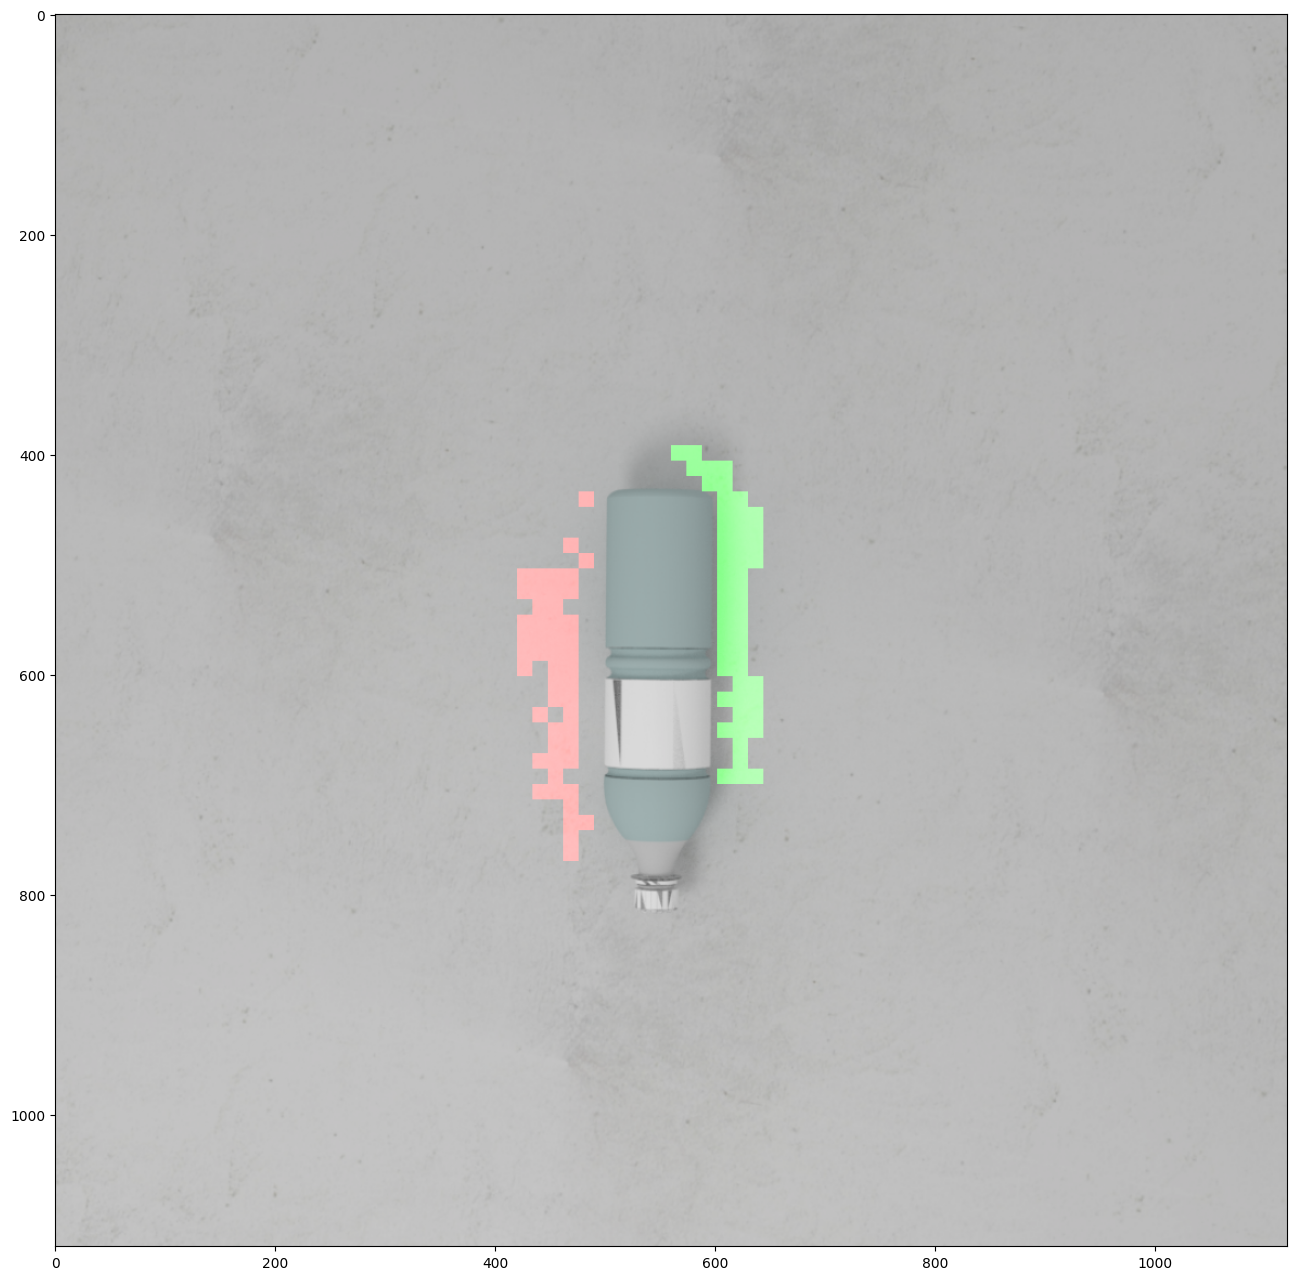

In [64]:


#origin_point = np.zeros((3, 60, 60))
#origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
#origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (840, 840), mode="nearest").squeeze()
#origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()
plt.figure(figsize=(16,16))
show_img = org_image + 0.5*preds_cp_left.cpu().detach().numpy() + 0.5 * preds_cp_right.numpy() 
#show_img = org_image + 0.5 * grasp_vis.numpy() + 0.5 * mask_vis.numpy()
#show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
plt.imshow(show_img)